<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2
## Part 6: Predictions for data in test.csv and Kaggle submission 


In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV,LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel

### Predictions for data in test.csv

In [2]:
%store -r df2_test

In [3]:
df2_test.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   
2  2414  528218130           60        RL          58.0     17104   Pave   
3  1989  902207150           30        RM          60.0      8520   Pave   
4   625  535105100           20        RL           NaN      9500   Pave   

  Alley Lot Shape Land Contour  ... 3Ssn Porch Screen Porch Pool Area Pool QC  \
0  Grvl       Reg          Lvl  ...          0            0         0     NaN   
1   NaN       IR1          Lvl  ...          0            0         0     NaN   
2   NaN       IR1          Lvl  ...          0            0         0     NaN   
3   NaN       Reg          Lvl  ...          0            0         0     NaN   
4   NaN       IR1          Lvl  ...          0          185         0     NaN   

  Fence Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  
0   NaN          NaN        0       4     2006        WD   
1   NaN          NaN        0       8     2006        WD   
2   NaN          NaN        0       9     2006        New  
3   NaN          NaN        0       7     2007        WD   
4   NaN          NaN        0       7     2009        WD   

[5 rows x 80 columns]

In [4]:
df2_test.shape

(878, 80)

In [5]:
List_to_replace_NA=['Alley','Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Fireplace Qu','Garage Type','Garage Finish','Garage Qual','Garage Cond','Pool QC','Fence','Misc Feature']

In [6]:
# We replace these 'NA's in these 14 columns with str 'placeholder'.
for i in range(14):
    df2_test[List_to_replace_NA[i]] = df2_test[List_to_replace_NA[i]].fillna('placeholder')

In [7]:
# Spot check if all this type of NAs have been replaced to 'placeholder's.
df2_test['Bsmt Cond'].unique()

array(['TA', 'Gd', 'placeholder', 'Fa'], dtype=object)

In [8]:
# Checking out those 'object' type of columns, inspect to make sure there are not any that should be numerical ones due to undefined entries.
df2_test.select_dtypes(include=['object']).columns

Index(['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type'],
      dtype='object')

In [9]:
# Now check how many NA values there are that are truly missing data.
with_null=df2_test.columns[df2_test.isna().any()].tolist()
len(with_null)
# There are 5 columns that are definitely with real missing data

5

In [10]:
missing_df=pd.DataFrame(df2_test.isna().sum()).reset_index() # w/o reset_index, df_cols become indices
# getting %nulls for cols with missing values
missing_df.columns = ['col', 'num_nulls'] # updating all col names in missing_df
missing_df['%nulls'] = missing_df['num_nulls']*100/len(df2_test) #creating a new col for %nulls (num_nulls/df_len)
missing_df[missing_df['num_nulls']>0] # filter to only cols with any nulls

col  num_nulls     %nulls
4    Lot Frontage        160  18.223235
26   Mas Vnr Type          1   0.113895
27   Mas Vnr Area          1   0.113895
43     Electrical          1   0.113895
60  Garage Yr Blt         45   5.125285

We will impute for all the missing values as no rows will be allowed to be dropped following the submission rules.

In [11]:
# imputation transformer for completing missing values
imp = SimpleImputer(strategy = 'most_frequent')  # instantiate

In [12]:
imp_X = imp.fit_transform(df2_test) 

In [13]:
imp_X.shape

(878, 80)

In [14]:
df_X=pd.DataFrame(imp_X, columns =df2_test.columns)

In [15]:
# Check if there are no nan values in training dataset
df_X.columns[df_X.isna().any()]

Index([], dtype='object')

In [16]:
df_X.shape

(878, 80)

As df_X.info() shows that datatype in df_X are all object, now we convert those that should be numerical values.

In [17]:
for col in df_X.columns:
    #print(col)
    try:
        df_X[col]=pd.to_numeric(df_X[col])
    except:
        pass
        #print('error')

#### Next to dummify the categorical columns 

In [18]:
# dummify the training dataset first 
X_dummified= pd.get_dummies(df_X, drop_first=True)

In [19]:
print(X_dummified.shape)

(878, 244)


We can see that there are 259 columns in the training dataset, whereas only 229 columns in the test dataset. For consistency we need to use the columns in the training dataset to complete the columns in the test dataset. 

In [20]:
%store -r X1

In [21]:
# An outer join to include all the columns that exist in training dataset but asbsent from test dataset.
X_joined=X_dummified.align(X1, axis=1)[0].fillna(0)

In [22]:
len(X_joined.columns)

272

As we see the number of columns in the outer joined is larger than 259, we need to do the similar action on the training dataset.

In [23]:
col_X1=X1.columns

In [24]:
col=X_joined.columns

In [25]:
#Finding out the columns brought in by X_dummified, but don't exist in X1
in_df_not_in_X1=[]
for i in col:
    if i in col_X1:
        pass
    else:
        in_df_not_in_X1.append(i)

In [26]:
in_df_not_in_X1

['Exterior 1st_PreCast',
 'Exterior 2nd_Other',
 'Exterior 2nd_PreCast',
 'Heating_GasA',
 'Kitchen Qual_Po',
 'Mas Vnr Type_CBlock',
 'Roof Matl_Metal',
 'Roof Matl_Roll',
 'Sale Type_VWD']

In [27]:
#Drop these columns, as we don't have any information how they are going to affect the response variable.
X_joined.drop(in_df_not_in_X1,axis=1,inplace=True)

In [28]:
X_joined.shape

(878, 263)

In [29]:
# To check if the order of the columns in X_joined and X1 are exactly the same.
different=[]
for i in range(263):
    if X_joined.columns[i]==X1.columns[i]:
        pass
    else:
        different.append(i)
different

[]

In [30]:
%store -r ss

In [31]:
%store -r reg

In [32]:
X_scaled_test=ss.transform(X_joined)

In [33]:
y_predict=reg.predict(X_scaled_test)

In [34]:
save=pd.DataFrame(data=df2_test['Id'],columns=['Id'])

In [35]:
save['SalePrice']=y_predict

In [36]:
save.sort_values(by=['Id'],inplace=True)

In [37]:
save.reset_index(drop=True,inplace=True)

In [38]:
save.index=save.index+1

In [39]:
save.head()

Id      SalePrice
1   2  115756.957918
2   4  259789.141683
3   6  192024.638324
4   7  224739.051387
5  17  213191.513865

In [40]:
save.to_csv('../datasets/sub_reg.csv',index=False)

### Some overreview on the predicted SalePrice 

C:\Users\Cathy\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


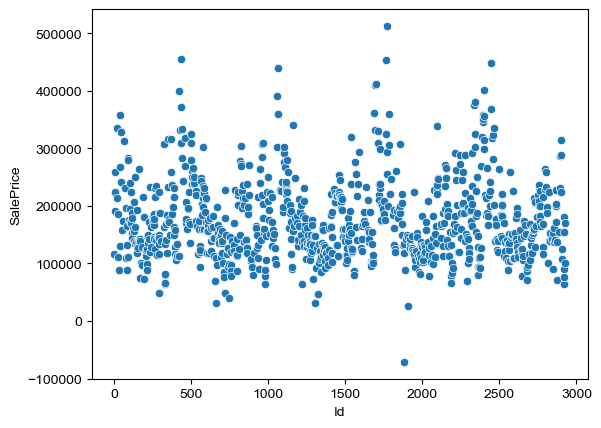

In [41]:
sns.scatterplot(save['Id'],save['SalePrice'])
sns.set(rc={'figure.figsize':(6.5,4)})

In [42]:
# Now we add the predicted saleprice back to the dataframe containing all the original feature variables (after imputation).
df3=df_X
df3['PredictedPrice']=y_predict

In [43]:
df3['Neighborhood']

0      OldTown
1       Sawyer
2      Gilbert
3      OldTown
4        NAmes
        ...   
873     NWAmes
874      NAmes
875     Sawyer
876      NAmes
877      NAmes
Name: Neighborhood, Length: 878, dtype: object

<AxesSubplot:title={'center':'Predicted SalePrice by Neighborhood'}, xlabel='Neighborhood', ylabel='Mean Predicted SalePrice'>

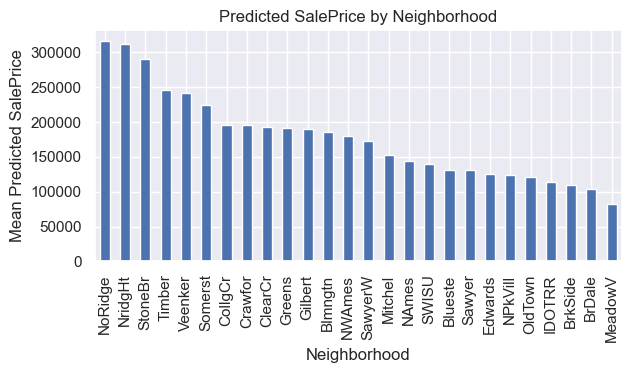

In [44]:
by_neighborhood2 = df3.groupby(['Neighborhood'])['PredictedPrice'].mean()
by_neighborhood2.sort_values(ascending=False,inplace=True)
by_neighborhood2.plot(kind='bar', title='Predicted SalePrice by Neighborhood', ylabel='Mean Predicted SalePrice',
         xlabel='Neighborhood', figsize=(6.8, 3))

In [45]:
plt.savefig('../pictures/Predicted SalePrice by Neighnorhood.PNG')

<Figure size 650x400 with 0 Axes>

As foreseened based on the high coefficients in Part 5, neiborhood being NoRidge, NridgHt and StoneBr does contribute to a higher saleprice given all the other features being equal.